# Continuity graph analysis

Apart from creating [graphs from individual street stegments](./convert.ipynb), you can create graphs based on identified [continuity strokes](./coins.ipynb).

In [68]:
import geopandas as gpd
import momepy
import networkx as nx

Given the `momepy.COINS` object, you can generate a graph representation based on strokes and their intersections.

## Generate strokes and continuity graph

Load the example street network.

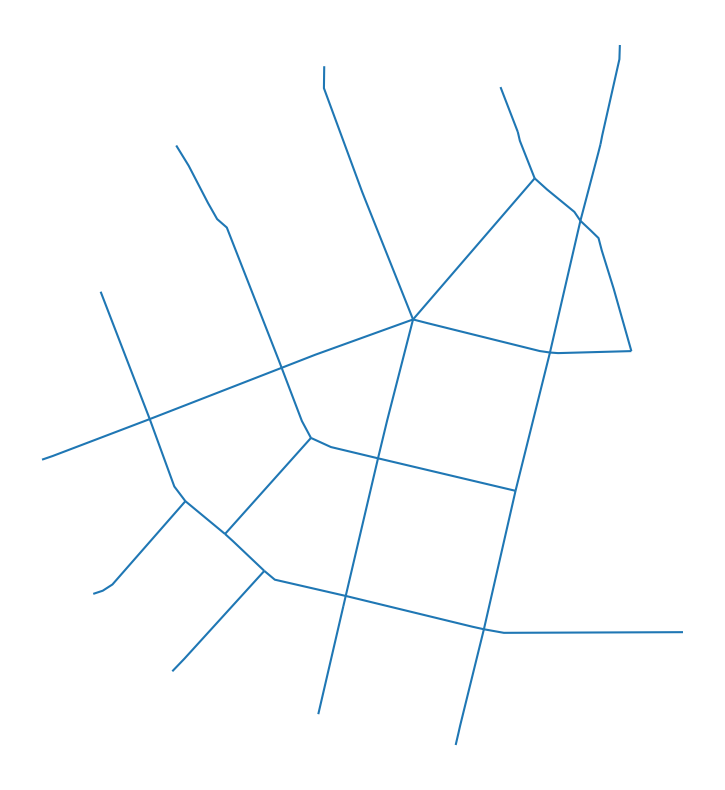

In [69]:
gdf = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")
gdf.plot(figsize=(10, 10)).set_axis_off()

`COINS` allows to find strokes, that are sets of edges with a natural continuity:

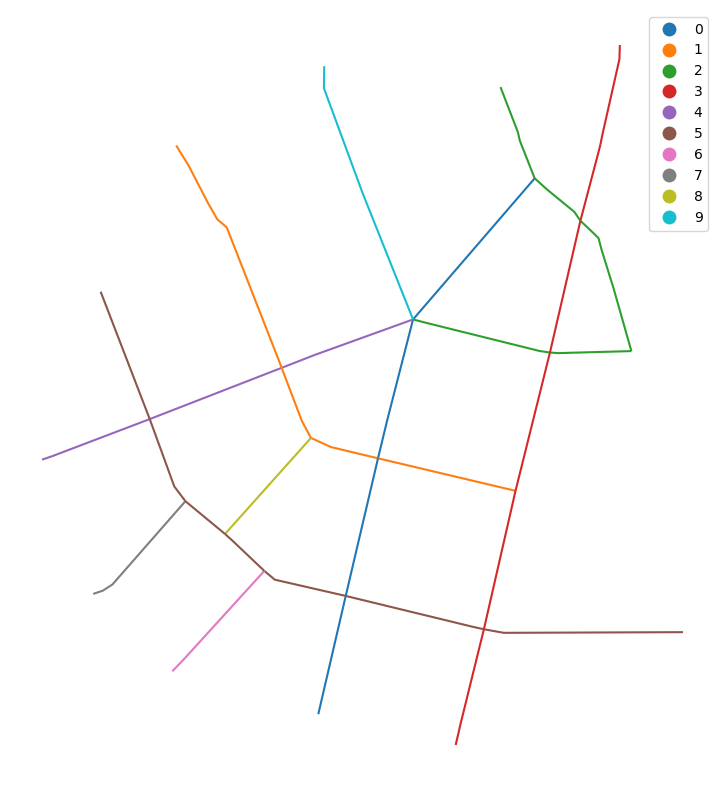

In [70]:
coins = momepy.COINS(gdf)
gdf.plot(
    coins.stroke_attribute(), figsize=(10, 10), categorical=True, legend=True
).set_axis_off()

From this, you can create a continuity graph, where each stroke is a node. If two strokes intersect, we add an edge between the two strokes:

In [71]:
continuity_graph = momepy.coins_to_nx(coins)

You can visualise the graph by mapping nodes to a point on the continuity stroke.

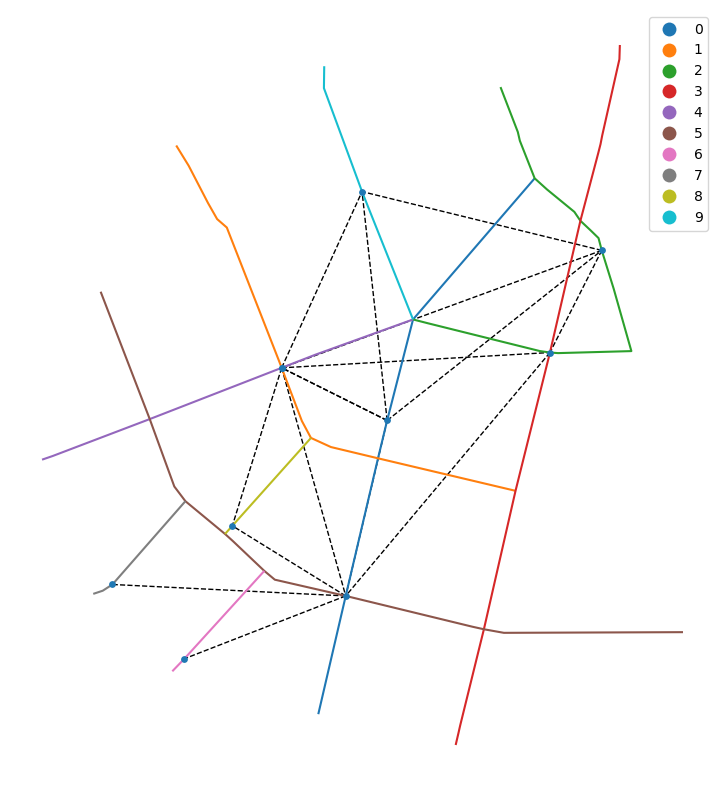

In [83]:
ax = (
    coins.stroke_gdf()
    .reset_index()  # reset to get stroke_group as a column
    .plot("stroke_group", categorical=True, legend=True, figsize=(10, 10))
)
nx.draw(
    continuity_graph,
    {
        # get positions of nodes as representative points of strokes
        n: geom.representative_point().coords[0]
        for n, geom in nx.get_node_attributes(
            continuity_graph, "geometry"
        ).items()
    },
    node_size=15,
    style="dashed",
    ax=ax,
)

This is a specific graph that holds some additional attributes, useful for visualisation of computation. Like any other momepy-generated graph, it can be converted back to `GeoDataFrame`s using `momepy.nx_to_gdf`.

In [16]:
strokes, edges = momepy.nx_to_gdf(continuity_graph)

`strokes` represents the individual strokes.

In [17]:
strokes.head()

,edge_indices,geometry,stroke_length,connectivity,nodeID
0,"[0, 5, 17, 20, 21]","LINESTRING (1603278.899 6463669.186, 1603283.7...",839.566684,0,0
1,"[1, 16, 19, 33]","LINESTRING (1603077.5 6464475.323, 1603085.515...",759.090043,0,1
2,"[2, 4, 14, 15, 22, 23]","LINESTRING (1603537.194 6464558.112, 1603557.6...",744.757934,0,2
3,"[3, 7, 24, 25, 26, 31]","LINESTRING (1603706.388 6464617.784, 1603705.7...",1019.709508,0,3
4,"[6, 8, 9]","LINESTRING (1603413.206 6464228.73, 1603274.45...",562.246691,0,4


While `edges`, represent the connections. Given there's no geometry associated, it is returned as a pandas `DataFrame`.

In [18]:
edges.head()

,angles,number_connections,node_start,node_end
0,"[62.30218235695145, 63.647466378271766]",2,0,2
1,[36.134980718680936],1,0,9
2,[29.396028363390094],1,0,4
3,"[89.74560192447649, 89.75267804978043]",2,0,1
4,"[89.42915166171285, 89.56623033507175]",2,0,5


## Computing metrics on the continuity graph

Using the continuity graph, you can compute several metrics. Some are classical metrics, already implemented in Networkx. For instance, the degree shows us the number of edges for each node -- in the case of the continuity graph, where nodes represent strokes and edges represent intersections between strokes, the (stroke) degree indicates the number of each stroke's intersections with other strokes:

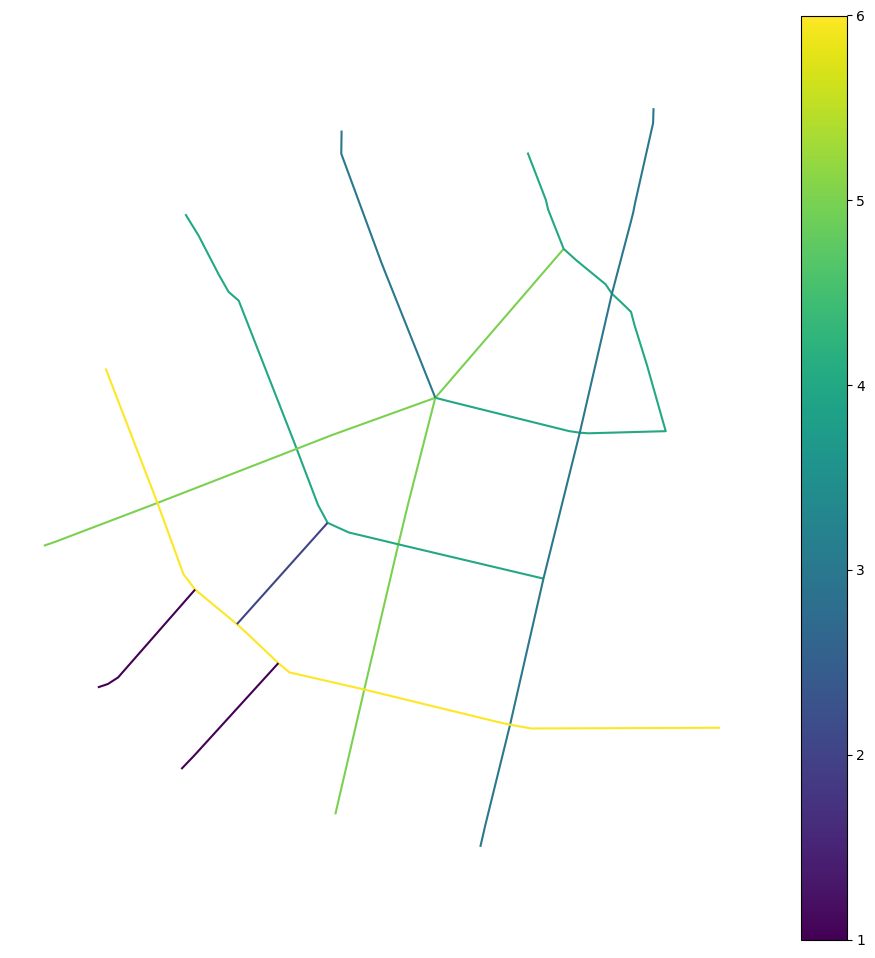

In [19]:
nx.set_node_attributes(
    continuity_graph, dict(nx.degree(continuity_graph)), "stroke_degree"
)
strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot("stroke_degree", figsize=(12, 12), legend=True).set_axis_off()

Instead of the maximum length travelled across the street network, the diameter of a continuity graph is the maximum number of "turns" one has to do to travel across the street network. By turns we mean a change of stroke: since strokes are following the natural continuity of the edges, staying on the same stroke is equivalent to going as straight as possible.

In [20]:
nx.diameter(continuity_graph)

3

In this case, the diameter of the continuity graph is 3, meaning that we can reach any place from any other place by making at most 3 "turns".

In a similar way, we can compute centrality metrics. A high betweenness stroke will be one used to travel the simplest paths, meaning the path with the least amount of "turns".

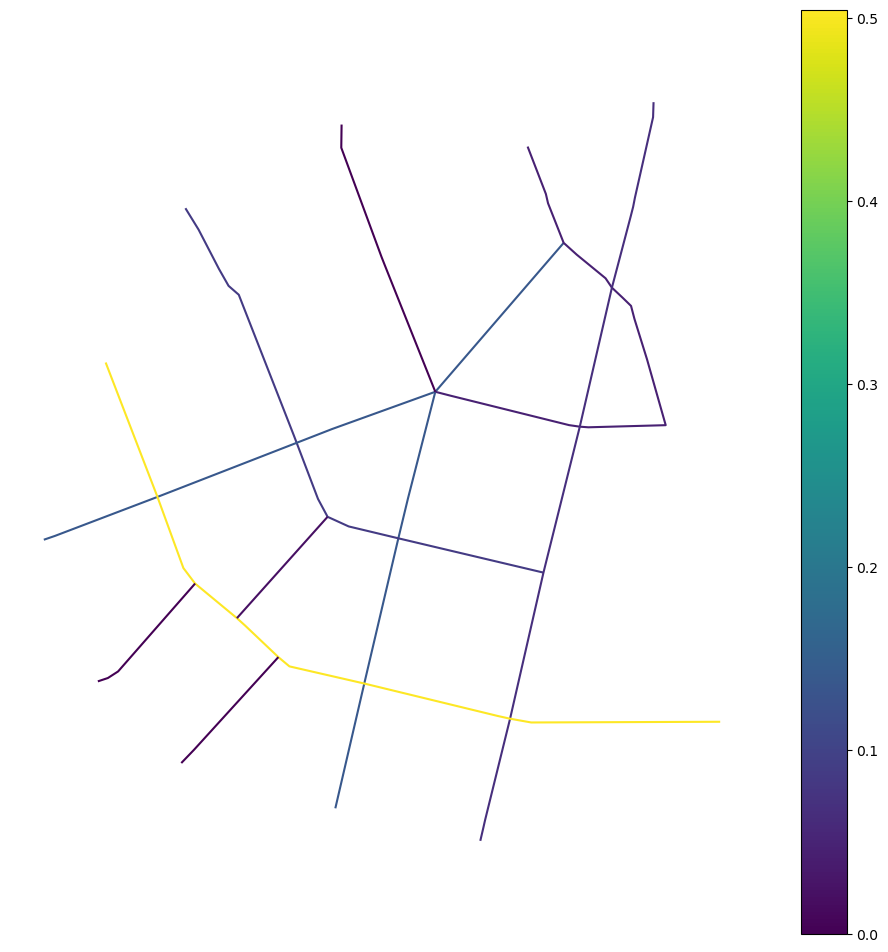

In [21]:
nx.set_node_attributes(
    continuity_graph,
    dict(nx.betweenness_centrality(continuity_graph)),
    "stroke_betweenness",
)

strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot("stroke_betweenness", figsize=(12, 12), legend=True).set_axis_off()

In the plot above, you can see that the stroke at the bottom of the street network is a hub of high betweenness: when starting out from this stroke, you can reach all but three other strokes in the network in one single turn. 

If you want to move the information back to original street segments, you can map it using the `edge_indices` column.

In [ ]:
gdf["stroke_betweenness"] = strokes.explode("edge_indices").set_index(
    "edge_indices"
)["stroke_betweenness"]
gdf.head()

,geometry,stroke_id,stroke_betweenness
0,"LINESTRING (1603585.64 6464428.774, 1603413.20...",0,0.136574
1,"LINESTRING (1603268.502 6464060.781, 1603296.8...",1,0.087963
2,"LINESTRING (1603607.303 6464181.853, 1603592.8...",2,0.046296
3,"LINESTRING (1603678.97 6464477.215, 1603675.68...",3,0.067130
4,"LINESTRING (1603537.194 6464558.112, 1603557.6...",2,0.046296


On a continuity graph, closeness centrality is equivalent to the integration metric in Space Syntax:

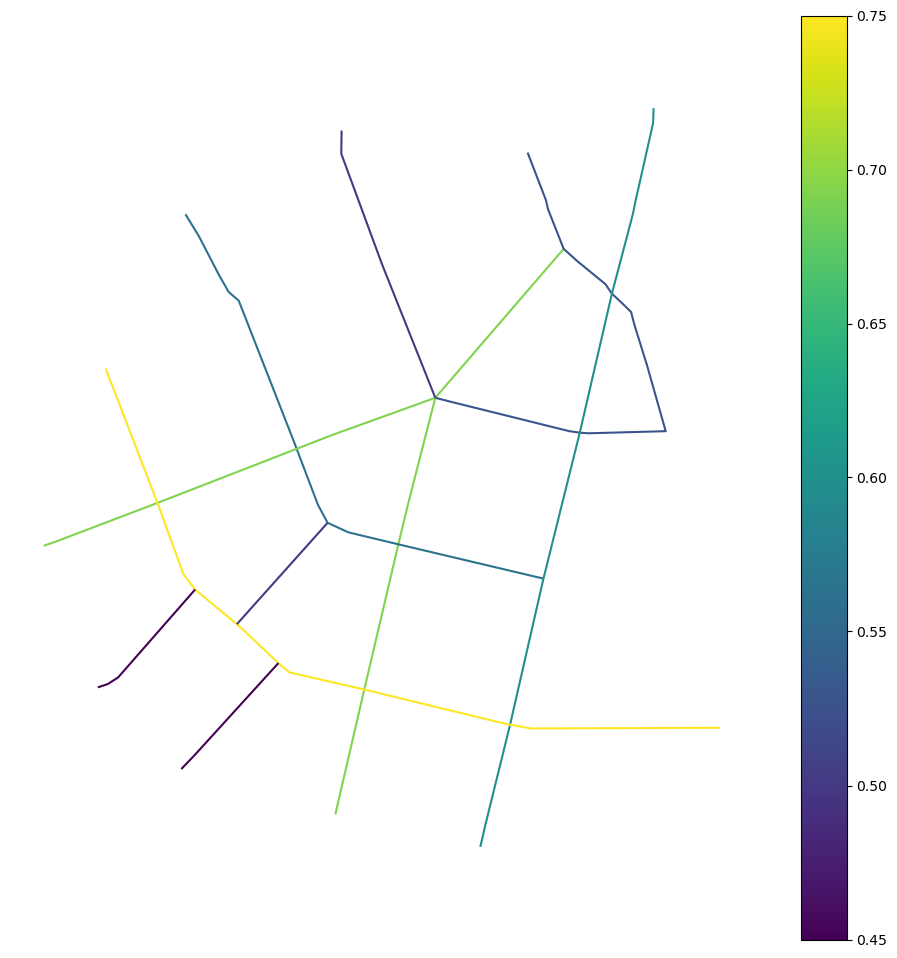

In [23]:
nx.set_node_attributes(
    continuity_graph,
    dict(nx.closeness_centrality(continuity_graph)),
    "stroke_closeness",
)
strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot("stroke_closeness", figsize=(12, 12), legend=True).set_axis_off()

On top of classical metrics that can all be computed on the continuity graph, `momepy` defines several new metrics for strokes.

### Stroke access

Access is defined as the difference between the connectivity (the number of street segments intersecting with a stroke) and the degree (the number of strokes intersecting with another stroke). A simple illustration is that for a T-intersection, the degree and the connectivity is the same, while for an X-intersection, connectivity is higher than degree.

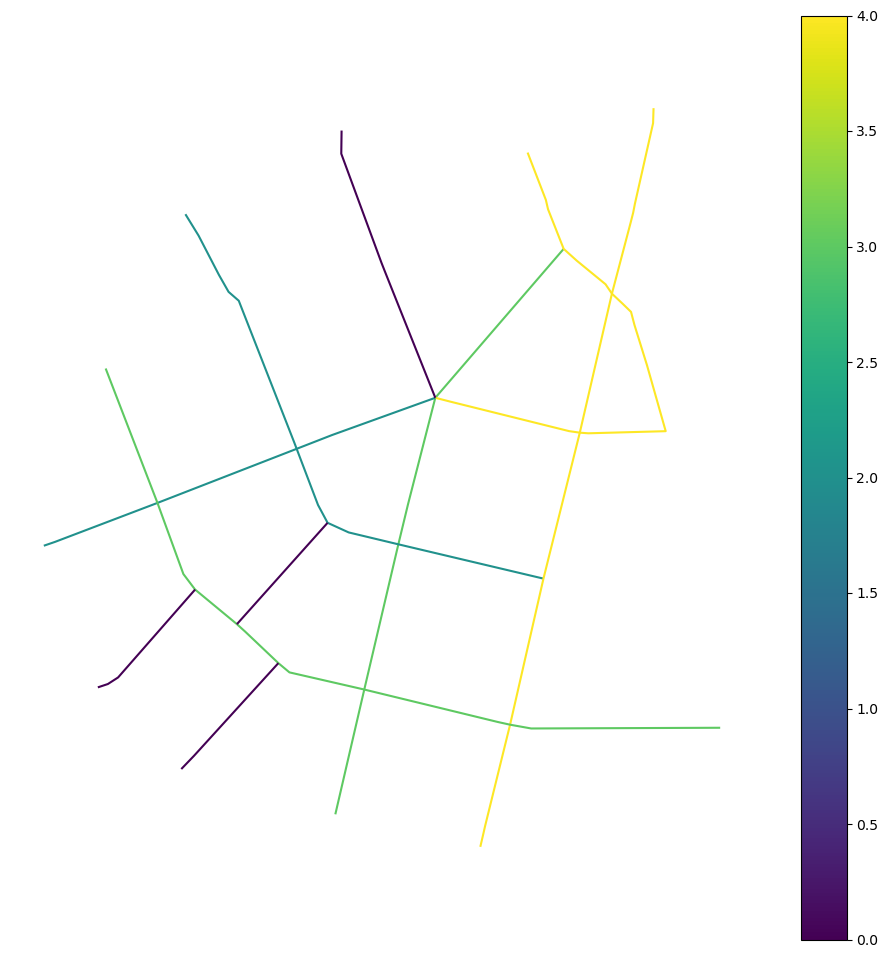

In [24]:
continuity_graph = momepy.stroke_access(continuity_graph)
strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot("stroke_access", figsize=(12, 12), legend=True).set_axis_off()

### Stroke spacing

Spacing is the average length between connections, dividing the total length of the stroke by its connectivity.

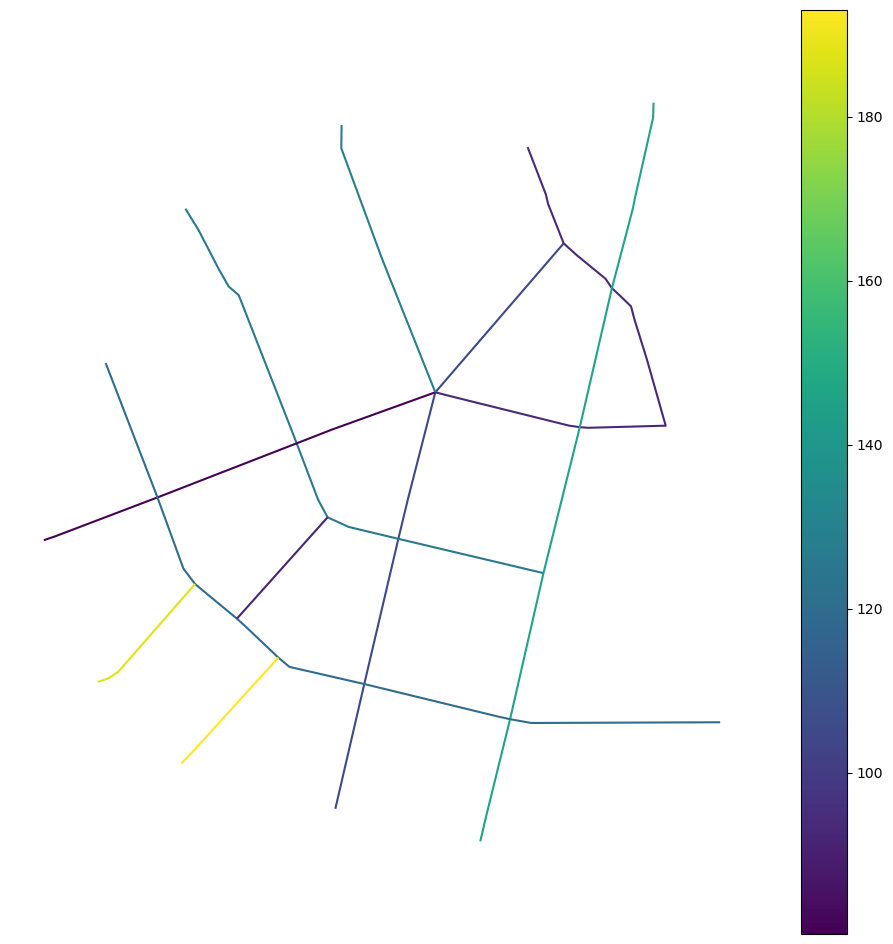

In [25]:
continuity_graph = momepy.stroke_spacing(continuity_graph)
strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot("stroke_spacing", figsize=(12, 12), legend=True).set_axis_off()

### Stroke orthogonality

Orthogonality is the average sine of the minimum angles between the stroke and its connections. It varies between 0 and 1, from low to right angles.

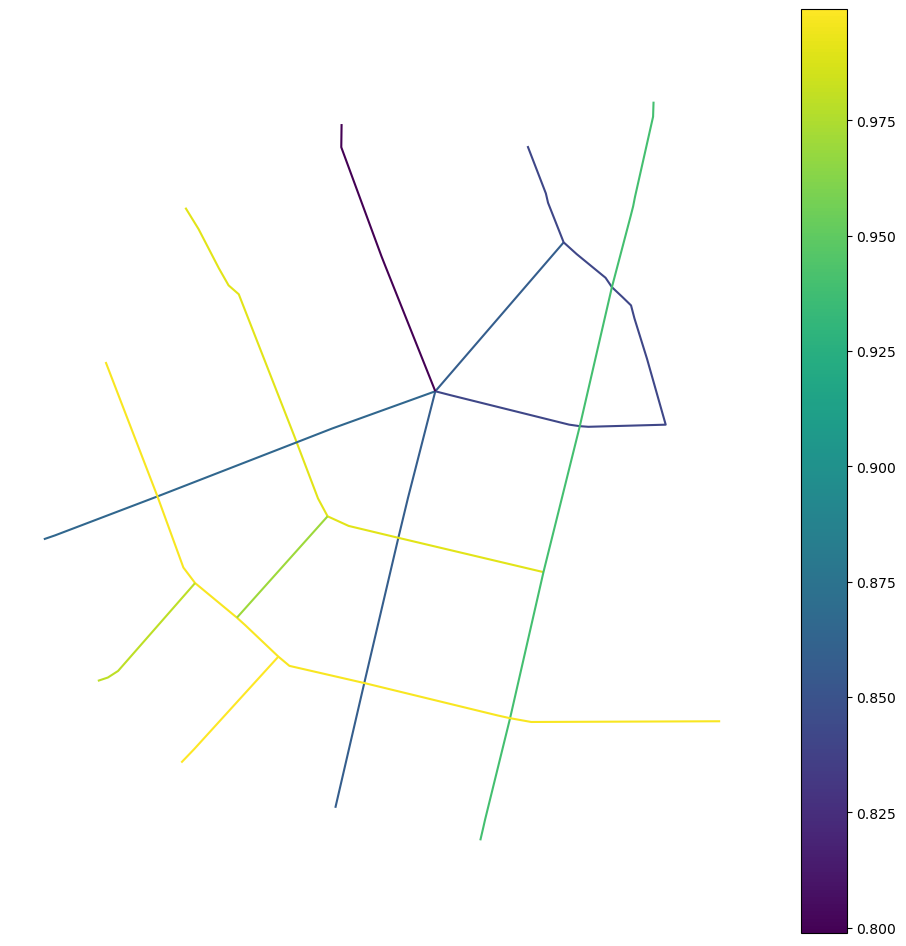

In [ ]:
continuity_graph = momepy.stroke_orthogonality(continuity_graph)
strokes, edges = momepy.nx_to_gdf(continuity_graph)

strokes.plot(
    "stroke_orthogonality", figsize=(12, 12), legend=True
).set_axis_off()

## Using OpenStreetMap data

In [27]:
import osmnx as ox

In [29]:
streets_graph = ox.graph_from_place(
    "Vicenza, Vicenza, Italy", network_type="drive"
)
streets_graph = ox.projection.project_graph(streets_graph)

streets = ox.graph_to_gdfs(
    ox.convert.to_undirected(streets_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

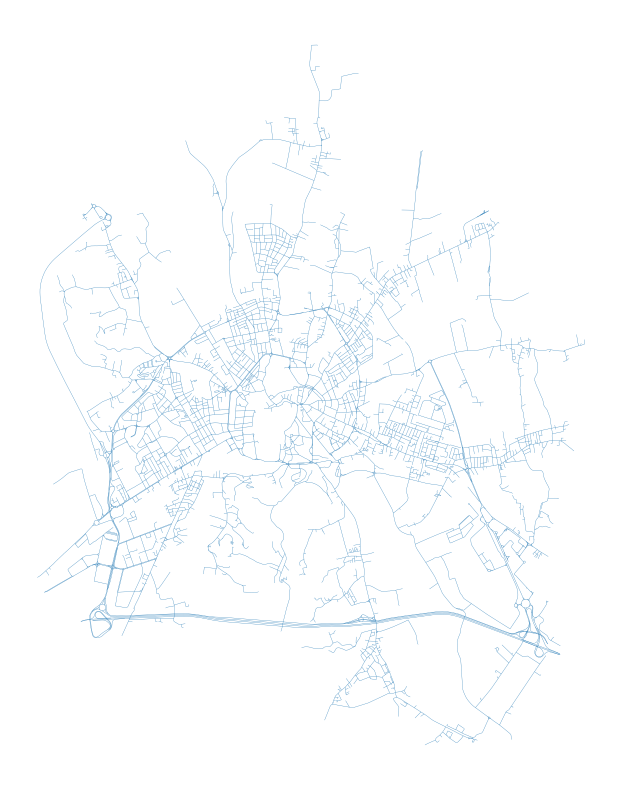

In [30]:
streets.plot(figsize=(10, 10), linewidth=0.2).set_axis_off()

In [31]:
continuity = momepy.COINS(streets)
continuity_graph = momepy.coins_to_nx(continuity)

Measure generic graph-metrics.

In [32]:
nx.set_node_attributes(
    continuity_graph,
    dict(nx.closeness_centrality(continuity_graph)),
    "stroke_closeness",
)

Or continuity-based ones.

In [33]:
continuity_graph = momepy.stroke_orthogonality(continuity_graph)

Convert back to GeoDataFrame.

In [34]:
strokes, edges = momepy.nx_to_gdf(continuity_graph)

And visualise.

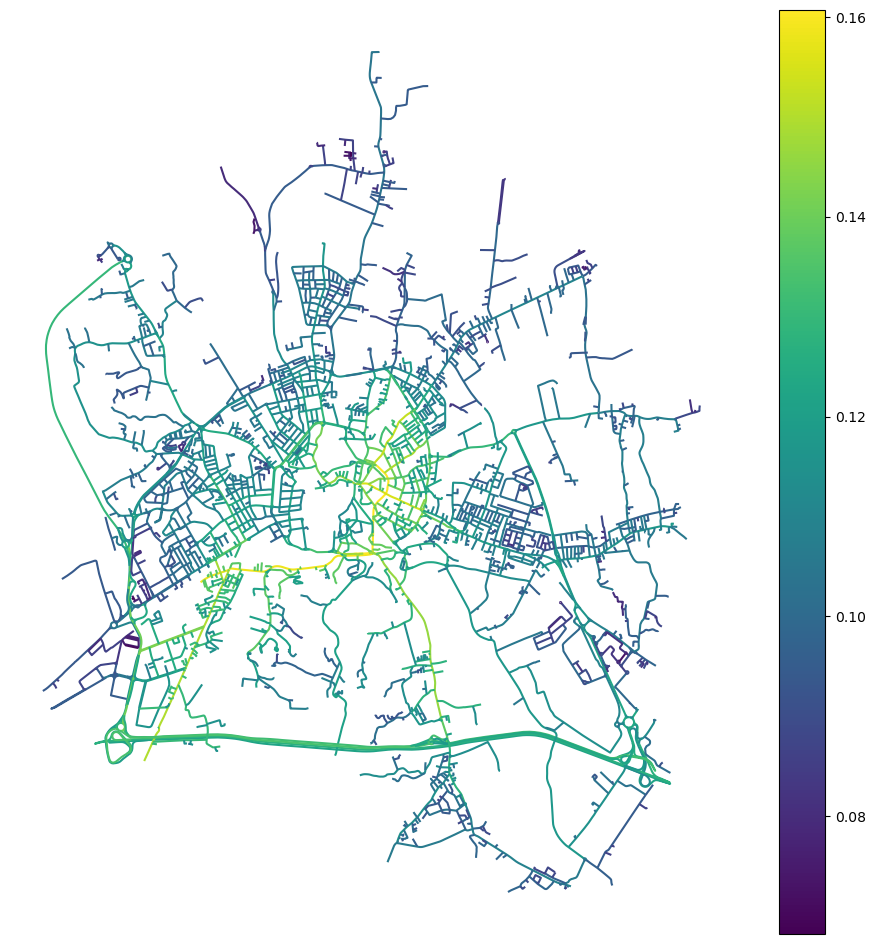

In [35]:
strokes.plot("stroke_closeness", figsize=(12, 12), legend=True).set_axis_off()

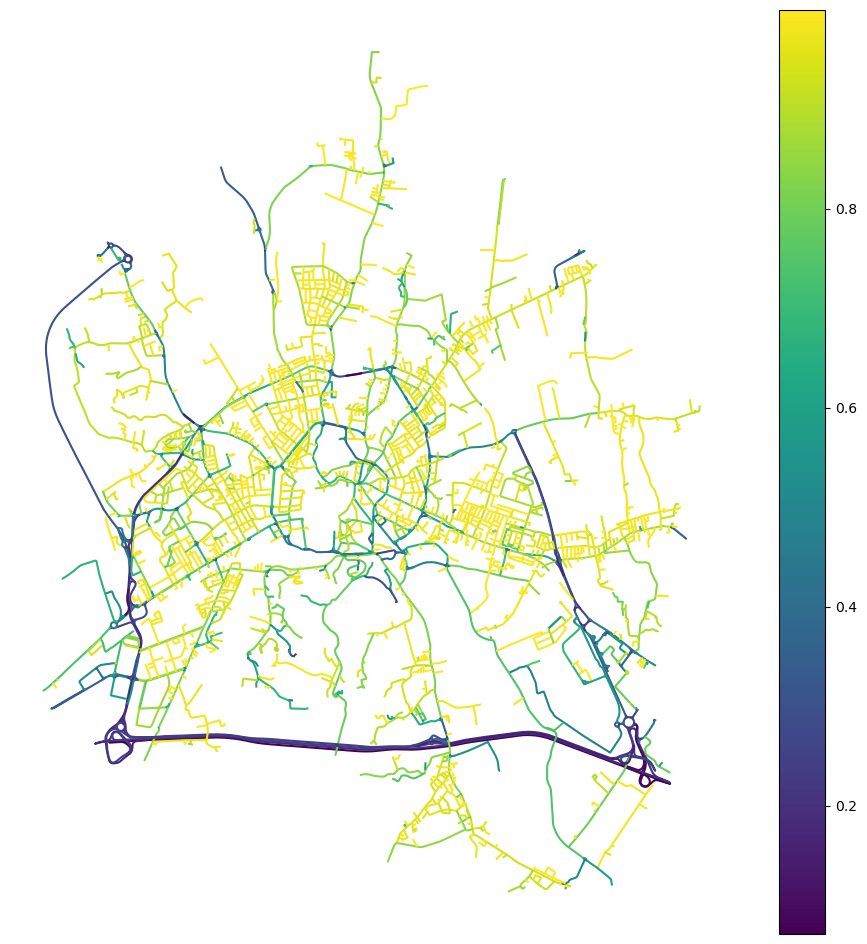

In [ ]:
strokes.plot(
    "stroke_orthogonality", figsize=(12, 12), legend=True
).set_axis_off()

## References

For COINS, refer to *Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. 2021. An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science, 48(8), 2188-2205. [https://doi.org/10.1177/2399808320967680](https://doi.org/10.1177/2399808320967680)*

For the geometric metrics on the dual graph, refer to *El Gouj, H., Rincón-Acosta, C. and Lagesse, C., 2022. Urban morphogenesis analysis based on geohistorical road data. Applied Network Science, 7(1), p.6 [https://doi.org/10.1007/s41109-021-00440-0](https://doi.org/10.1007/s41109-021-00440-0).*.